## Photometry (testing)

load packages

In [48]:
import numpy as np
import scipy.optimize as fitter
import matplotlib.pyplot as plt
import os, json, random, cv2, gc, copy
from PIL import Image
from numpyencoder import NumpyEncoder
import rawpy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import astropy.units as u
from astropy.io import fits
from astropy import wcs
from specutils import Spectrum1D
from astropy.convolution import Box1DKernel
from specutils.manipulation import convolution_smooth

from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
from detectron2.engine import DefaultTrainer, SimpleTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils import comm
from detectron2.engine import DefaultPredictor
import torch

import utils

# for testing purpose
import importlib
importlib.reload(utils)



<module 'utils' from '/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/Meteor spectrum/Metspec/utils.py'>

global variables

In [ ]:
wavelengths = np.arange(400, 800)*u.nm
FWHM        = 0.5
lambda_Na   = 589.0*u.nm
lambda_Mg   = 518.3*u.nm
width       = 1000
height      = 1500

## Load network

In [8]:
out_dir = './output/'
os.makedirs(out_dir, exist_ok=True)

cfg = get_cfg()

cfg.OUTPUT_DIR = out_dir
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fake_meteors",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.TEST.DETECTIONS_PER_IMAGE = 220 # max 200 stars + 20 meteors
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 5.0
cfg.MODEL.ROI_KEYPOINT_HEAD.NORMALIZE_LOSS_BY_VISIBLE_KEYPOINTS = True
cfg.MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT = 1.
cfg.MODEL.ROI_KEYPOINT_HEAD.CONV_DIMS = tuple(512 for _ in range(8))
cfg.KEYPOINT_ON = True

# MetadataCatalog.get("fake_meteors").set(thing_classes=["meteor"])
MetadataCatalog.get("fake_meteors").thing_classes = ['meteor', 'star']
MetadataCatalog.get("fake_meteors").keypoint_names = ['1', '2', '3', '4']
MetadataCatalog.get("fake_meteors").keypoint_flip_map = ()
# del MetadataCatalog.get("fake_meteors").keypoint_connection_rules
MetadataCatalog.get("fake_meteors").keypoint_connection_rules=[('1', '2', (102, 204, 255)), ('3', '4', (255, 195, 77))]

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# del MetadataCatalog.get("fake_meteors").keypoint_names
# MetadataCatalog.get("fake_meteors").keypoint_names = ['1', '2', '3', '4']
cfg.MODEL.WEIGHTS = os.path.join('test', 'model_final.pth')

predictor = DefaultPredictor(cfg)

## Load and display the data

We load the images and plot a single picture to see what we have. 

(1000, 1500, 3) float64


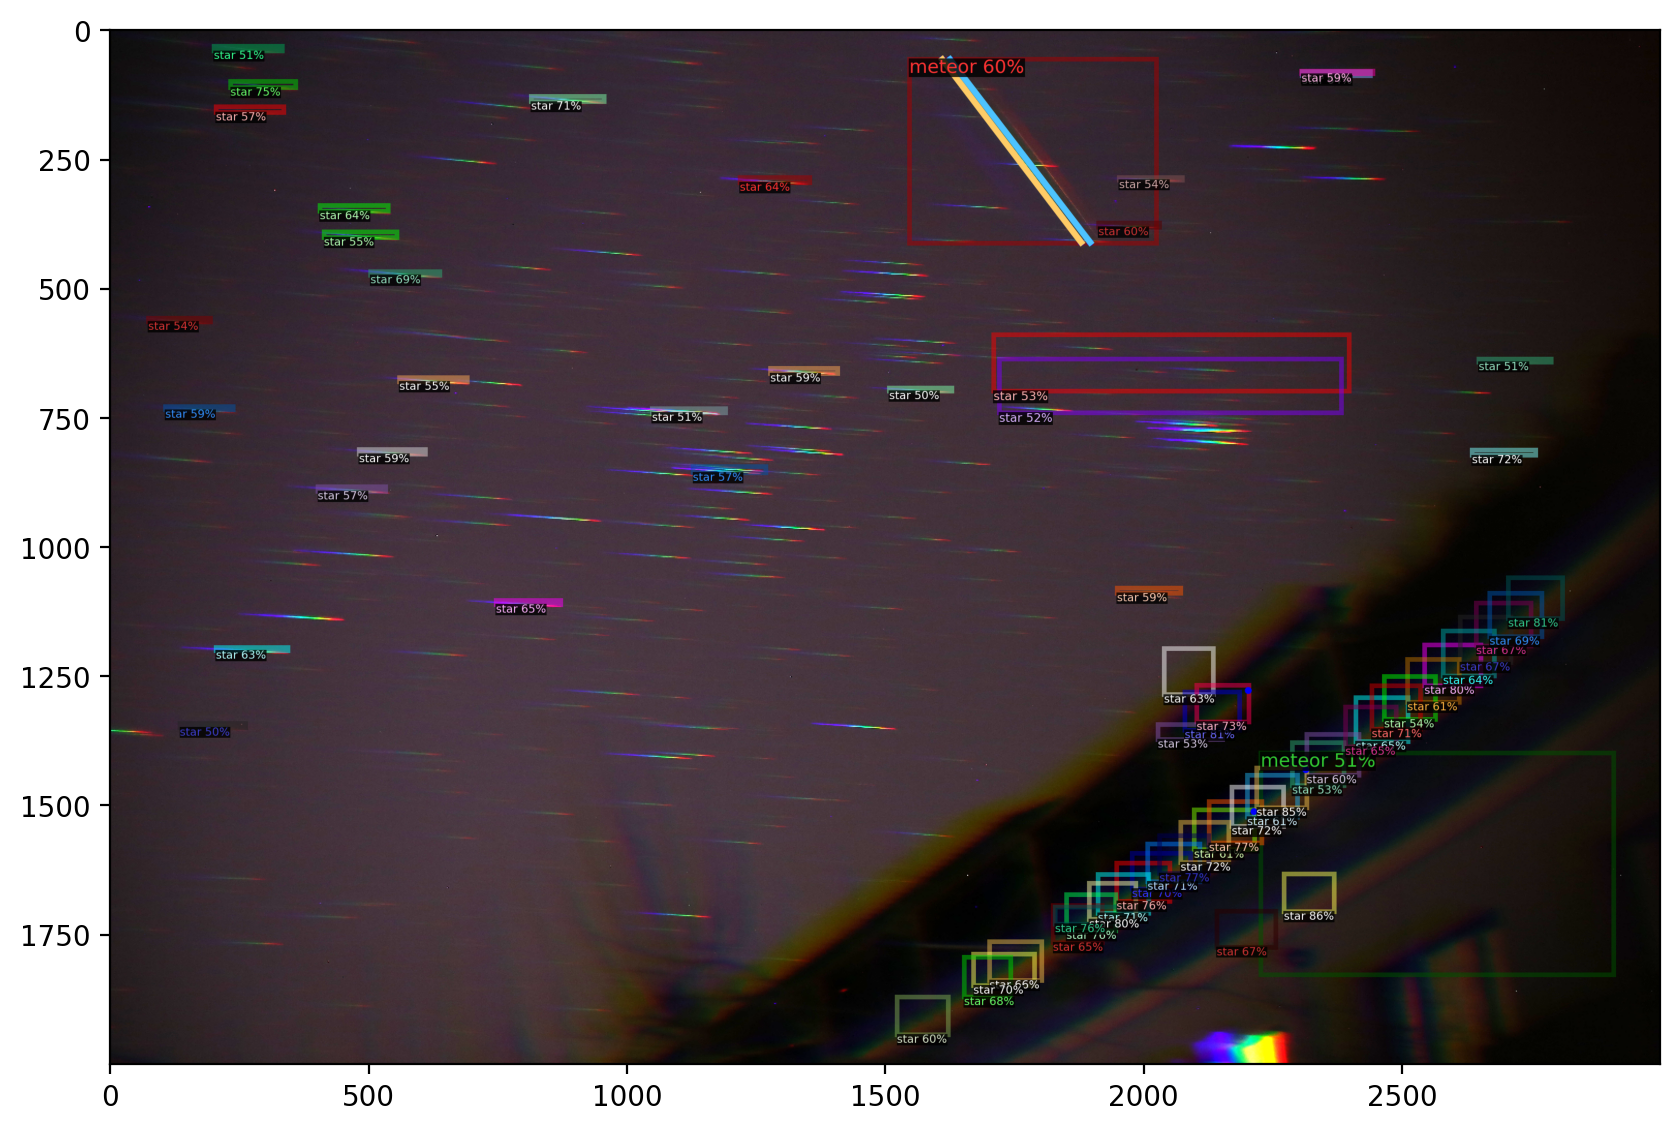

In [16]:
for im in [plt.imread("test/testimg2.jpg")]:
    im = cv2.resize(im, dsize=(1500, 1000), interpolation=cv2.INTER_CUBIC)
    im = im*2.
    print(im.shape, im.dtype)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=[10, 8])
    plt.imshow(out.get_image()[:, :, ::-1])

Proceed data acquisition from network result

In [126]:
# retrieve the result
classes = outputs["instances"].get('pred_classes').to('cpu')
keypoints = outputs["instances"].get('pred_keypoints').to('cpu')
boxes = outputs["instances"].get('pred_boxes').to('cpu')
scores = outputs["instances"].get('scores').to('cpu')

# filter to find the meteor, which is the meteor object with highest probability
meteor_box = boxes[classes==0][torch.where(scores[classes==0].max())].tensor.squeeze().type(torch.int16)
meteor_keypoints = keypoints[classes==0][torch.where(scores[classes==0].max())].squeeze().type(torch.int16)[:, :2]
meteor_center = boxes[classes==0][torch.where(scores[classes==0].max())].get_centers().squeeze().type(torch.int16)
print(meteor_box)
print(meteor_keypoints)
print(meteor_center)
assert meteor_box.shape==torch.Size([4])
assert meteor_keypoints.shape==torch.Size([4, 2])

# position data used for photometry
pos_Na = meteor_keypoints[0:2].numpy()
pos_Mg = meteor_keypoints[2:4].numpy()
FWHM = 3 #pixels 
box_height = meteor_box[2] - meteor_box[0]
box_width = 
box_center = meteor_center
radius_Na = 0.5
radius_Mg = 4

class ImgROI: 

    def __init__(self, box, xy1, xy2, xy3, xy4, roi_width, roi_height): 
        self.box = box
        self.xy1 = xy1
        self.xy2 = xy2
        self.xy3 = xy3
        self.xy4 = xy4
        self.tf = np.array()
    
    def img2roi(self, x, y): 
        return u, v
    
    def roi2img(self, u, v): 
        return x, y
    
    def get_box(self): 
        return
    
    def get_roi(self): 
        return




data = im
data2 = copy.deepcopy(data)
pos_Na

tensor([ 773,   27, 1012,  205], dtype=torch.int16)
tensor([[939, 205],
        [805,  28],
        [948, 205],
        [812,  28]], dtype=torch.int16)
tensor([893, 116], dtype=torch.int16)


array([[939, 205],
       [805,  28]], dtype=int16)

In [117]:
'''Na'''
for i in range(posxes_Na.size): 
    search_area = data2[int(posyes_Na[i]-radius_Na):int(posyes_Na[i]+radius_Na), int(posxes_Na[i]-radius_Na):int(posxes_Na[i]+radius_Na)]
    print(search_area)
    movex, movey= np.where(search_area==np.max(search_area))
    posxes_Na[i] += movex-radius_Na
    posyes_Na[i] += movey-radius_Na
    print(np.where(search_area==np.max(search_area)))
posxes_Na = np.squeeze(np.array(posxes_Na))
posyes_Na = np.squeeze(np.array(posyes_Na))
'''Mg'''
for i in range(posxes_Mg.size): 
    search_area = data2[int(posyes_Mg[i]-radius_Mg):int(posyes_Mg[i]+radius_Mg), int(posxes_Mg[i]-radius_Mg):int(posxes_Mg[i]+radius_Mg)]
    movex, movey= np.where(search_area==np.max(search_area))
    posxes_Mg[i] += movex-radius_Mg
    posyes_Mg[i] += movey-radius_Mg
    print(np.where(search_area==np.max(search_area)))
posxes_Mg = np.squeeze(np.array(posxes_Mg))
posyes_Mg = np.squeeze(np.array(posyes_Mg))
print(posxes_Na)
print(posyes_Na)
print(posxes_Mg)
print(posyes_Mg)


[[[ 70. 152. 112.]]]


ValueError: too many values to unpack (expected 2)

align the data. x is a function of y

In [ ]:
def model1(y, a0, a1, a2, a3):
    x = a0 + a1*y + a2*y**2 + a3*y**3
    return x

'''Na'''
# par0 = np.array([343.22518113027604,0.9173450017854576,-7.1964226363596e-05,-4.5461752381550485e-09,0])
par0 = np.array([0, 0, 0, 0])
par1, cov = fitter.curve_fit(model1, posyes_Na, posxes_Na, par0)
a0_Na = par1[0]
print(a0_Na)
a1_Na = par1[1]
print(a1_Na)
a2_Na = par1[2]
print(a2_Na)
a3_Na = par1[3]
print(a3_Na)
'''Mg'''
# par0 = np.array([278.3914708514378,0.9055719763444376,-3.978516991165482e-05,-2.237222073967861e-08,0])
par2, cov = fitter.curve_fit(model1, posyes_Mg, posxes_Mg, par0)
a0_Mg = par2[0]
print(a0_Mg)
a1_Mg = par2[1]
print(a1_Mg)
a2_Mg = par2[2]
print(a2_Mg)
a3_Mg = par2[3]
print(a3_Mg)

343.1838662923559
0.9172727494576399
-7.19702488384702e-05
-4.546832118800917e-09
263.45419253239265
1.0165791905428068
-0.0002871455297391486
1.5020141347843862e-07


assign the pixels to the wavelengths, then sum up the intensities. x is a function of s

In [ ]:
def model2(s, b0, b1): # using linear function
    x = b0 + b1*s
    return x

lambdas = np.arange(4000, 7000)
number = 7
spectra  = []
for i in range(number): # each lines
    spectrum = np.zeros(7000-4000) 
    posy = int(pos_center[1] - span_y/2 + span_y*i/(number-1))
    # pos_start = [pos_center[0] + int(-span_y/2*k - span_s/2 + span_y*i/(number-1)*k), pos_center[1] + int(-span_y/2 + span_y*i/(number-1))]
    for y in range(posy+width//2-width, posy+width//2):
        sum = np.zeros(7000-4000)
        '''give the map from wavelength to pixel'''
        par0 = np.array([0,0])
        posx_Na = model1(y, *par1)
        posx_Mg = model1(y, *par2)
        posx_Na = posx_Na - 10 + np.argmax(data[y,int(posx_Na)-10:int(posx_Na)+10]) # to align the spectra with the nearest maxima
        posx_Mg = posx_Mg - 10 + np.argmax(data[y,int(posx_Mg)-10:int(posx_Mg)+10])
        par3, cov = fitter.curve_fit(model2, [lambda_Na, lambda_Mg], [posx_Na, posx_Mg], par0, absolute_sigma=True)
        b0 = par3[0]
        b1 = par3[1]
        for index, lambda_ in enumerate(lambdas):
            # spectrum.append(np.sum(data2[pos_start[1]-FWHM//2:pos_start[1]+FWHM+1-FWHM//2, pos_start[0]+length]))
            # sum[index] = np.sum(data[y, int(model2(lambda_, b0, b1)+FWHM//2-FWHM):int(model2(lambda_, b0, b1)+FWHM//2)])
            '''sum all the wavelengths on this position'''
            sum[index] = data[y, int(model2(lambda_, b0, b1))]
            '''mark the data'''
            data2[y, int(model2(lambda_, b0, b1))] += 1000
        spectrum += sum

    spectra.append(spectrum)

Smooth the data

In [ ]:
box1d_kernel = Box1DKernel(width=20)
spectra_smooth = []
for spectrum in spectra: 
    spectrum = Spectrum1D(spectral_axis=lambdas*u.AA, flux=spectrum*u.Jy)
    spectrum = convolution_smooth(spectrum, box1d_kernel)
    spectra_smooth.append(spectrum)
spectra = np.array(spectra)

plot the annotated image

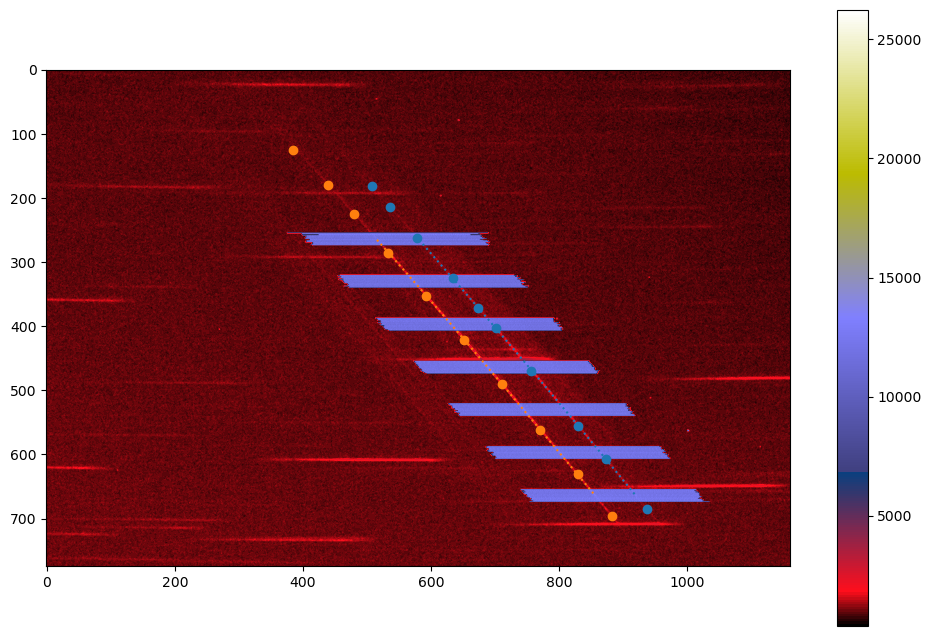

In [ ]:
plt.figure()
plt.imshow(data2, cmap = plt.cm.gist_stern)
plt.colorbar()
yfit=np.arange(pos_center[1] - span_y//2, pos_center[1] + span_y//2, dtype=np.float64)
plt.plot(model1(yfit, *par1), yfit, ':', model1(yfit, *par2), yfit, ':')
plt.scatter(posxes_Na,posyes_Na)
plt.scatter(posxes_Mg,posyes_Mg)


calculate the Gaussian parameters

plot the spectrum

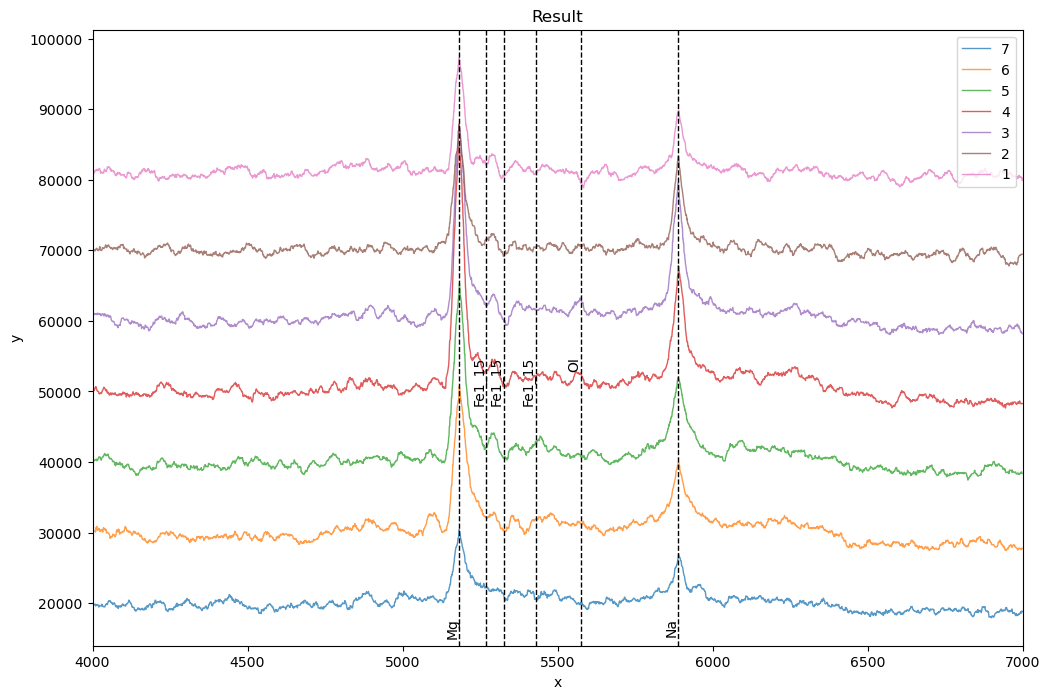

In [ ]:
plt.figure()

'''specturm'''

for i in range(number): 
    plt.plot(lambdas, spectra[i]+i*10000, label = number-i, linewidth=1, alpha=0.75)

'''spectral lines'''

plt.axvline( lambda_Na, color='k', linewidth=1, linestyle='--')
plt.text(    lambda_Na, 18000, 'Na', rotation=90, va='top', ha='right')
plt.axvline( lambda_Mg, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_Mg, 18000, 'Mg', rotation=90, va='top', ha='right')
plt.axvline( lambda_OI, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_OI, 55000, 'OI', rotation=90, va='top', ha='right')
plt.axvline( lambda_Fe1_15, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_Fe1_15, 55000, 'Fe1_15', rotation=90, va='top', ha='right')
plt.axvline( lambda_Fe1_152, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_Fe1_152, 55000, 'Fe1_15', rotation=90, va='top', ha='right')
plt.axvline( lambda_Fe1_153, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_Fe1_153, 55000, 'Fe1_15', rotation=90, va='top', ha='right')

plt.title('Result')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(4000, 7000)
plt.legend()
plt.show()

In [ ]:
def model3(x, A, sigma, z):
    return A*np.exp(-x**2/(2*sigma**2)) + z# without mu

par_Na = []
par_Mg = []
background = np.average(spectra[i,2500:3000])
for i in range(number):
    '''Na'''
    xfit = np.arange(-50, 50)
    par0 = np.ones(model3.__code__.co_argcount-1) # initial guess for parameters
    par, cov = fitter.curve_fit(model3, xfit, spectra[i,lambda_Na-4000-50:lambda_Na-4000+50]+i*10000, par0, absolute_sigma=True)
    par_Na.append(par)
    '''Mg'''
    xfit = np.arange(-50, 50)
    par0 = np.ones(model3.__code__.co_argcount-1) # initial guess for parameters
    par, cov = fitter.curve_fit(model3, xfit, spectra[i,lambda_Mg-4000-50:lambda_Mg-4000+50]+i*10000, par0, absolute_sigma=True)
    par_Mg.append(par)


plot the Na/Mg ratio

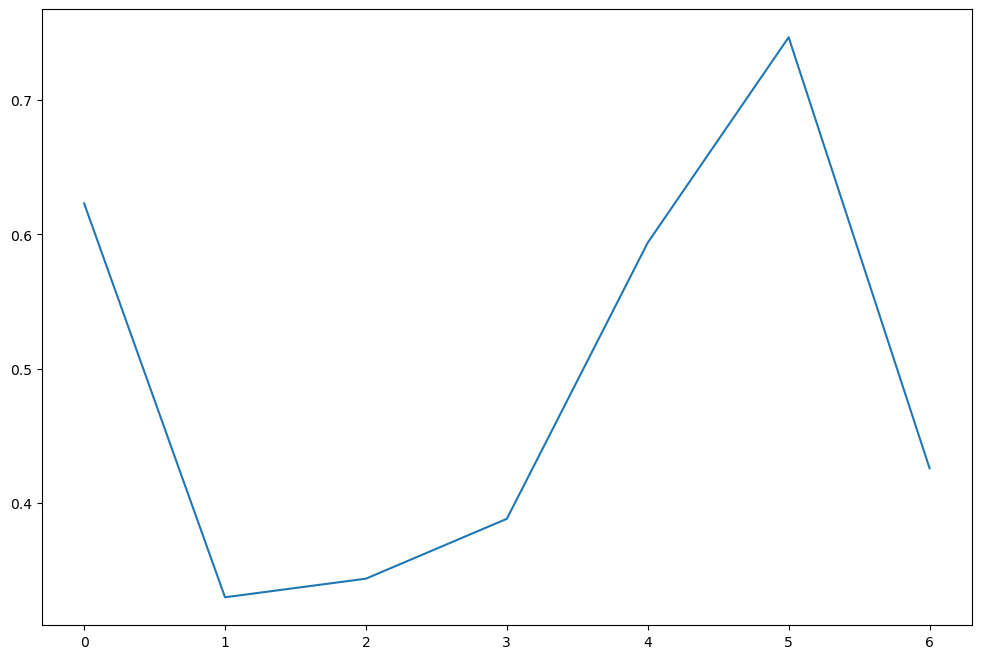

In [ ]:
A_Na = np.array(par_Na)[:,0]
A_Mg = np.array(par_Mg)[:,0]

plt.figure()

plt.plot(np.arange(number), np.array(A_Na)/np.array(A_Mg))

plt.show()

## First version of photometry code: 

In [104]:
'''./01/IMG_0241.fit'''
posxes_Na = np.array([937, 874, 830, 757, 702, 674, 634, 579, 536, 508], dtype=np.float64)
posyes_Na = np.array([686, 608, 556, 470, 403, 372, 325, 263, 214, 182], dtype=np.float64)
posxes_Mg = np.array([885, 831, 770, 710, 649, 592, 530, 482, 440, 389], dtype=np.float64)
posyes_Mg = np.array([700, 634, 561, 490, 419, 353, 282, 227, 180, 123], dtype=np.float64)
FWHM = 3 #pixels 
# span_s = 400 #abs((pos_Mg[0][0]-pos_Mg[0][1]//k) - (pos_Na[0][0]-pos_Na[0][1]//k)) * 6 # span on the spectrum axis
span_y = 400
width = 20
pos_center = [600, 465]
radius_Na = 0.5
radius_Mg = 4


open file

In [106]:
with fits.open('./test/testimg2_clip.fit') as hdu: 
    data = hdu[0].data #numpy array, inverse X and Y
data2 = copy.deepcopy(data)

Spectral constants

In [107]:
lambda_Na = 5890
lambda_Mg = 5183
lambda_Fe1_15 = 5270
lambda_Fe1_152 = 5327
lambda_Fe1_153 = 5429
lambda_OI = 5577

find the brightest value near the position

In [114]:
'''Na'''
for i in range(posxes_Na.size): 
    search_area = data2[int(posyes_Na[i]-radius_Na):int(posyes_Na[i]+radius_Na), int(posxes_Na[i]-radius_Na):int(posxes_Na[i]+radius_Na)]
    movex, movey= np.where(search_area==np.max(search_area))
    print(search_area, movex, movey)
    posxes_Na[i] += movex-radius_Na
    posyes_Na[i] += movey-radius_Na
    print(np.where(search_area==np.max(search_area)))
posxes_Na = np.squeeze(np.array(posxes_Na))
posyes_Na = np.squeeze(np.array(posyes_Na))
'''Mg'''
for i in range(posxes_Mg.size): 
    search_area = data2[int(posyes_Mg[i]-radius_Mg):int(posyes_Mg[i]+radius_Mg), int(posxes_Mg[i]-radius_Mg):int(posxes_Mg[i]+radius_Mg)]
    movex, movey= np.where(search_area==np.max(search_area))
    posxes_Mg[i] += movex-radius_Mg
    posyes_Mg[i] += movey-radius_Mg
    print(np.where(search_area==np.max(search_area)))
posxes_Mg = np.squeeze(np.array(posxes_Mg))
posyes_Mg = np.squeeze(np.array(posyes_Mg))
print(posxes_Na)
print(posyes_Na)
print(posxes_Mg)
print(posyes_Mg)


[[1320]] [0] [0]
(array([0]), array([0]))
[[12529]] [0] [0]
(array([0]), array([0]))
[[1529]] [0] [0]
(array([0]), array([0]))
[[12502]] [0] [0]
(array([0]), array([0]))
[[12397]] [0] [0]
(array([0]), array([0]))
[[1467]] [0] [0]
(array([0]), array([0]))
[[12465]] [0] [0]
(array([0]), array([0]))
[[11223]] [0] [0]
(array([0]), array([0]))
[[1220]] [0] [0]
(array([0]), array([0]))
[[1013]] [0] [0]
(array([0]), array([0]))
(array([6]), array([2]))
(array([5]), array([3]))
(array([4]), array([4]))
(array([6]), array([2]))
(array([4]), array([4]))
(array([4]), array([4]))
(array([4]), array([4]))
(array([4]), array([4]))
(array([4]), array([4]))
(array([2]), array([1]))
[935.5 872.5 828.5 755.5 700.5 672.5 632.5 577.5 534.5 506.5]
[684.5 606.5 554.5 468.5 401.5 370.5 323.5 261.5 212.5 180.5]
[885. 827. 770. 714. 652. 592. 535. 479. 439. 379.]
[693. 626. 561. 487. 422. 353. 287. 224. 179. 118.]


align the data. x is a function of y

In [110]:
def model1(y, a0, a1, a2, a3):
    x = a0 + a1*y + a2*y**2 + a3*y**3
    return x

'''Na'''
# par0 = np.array([343.22518113027604,0.9173450017854576,-7.1964226363596e-05,-4.5461752381550485e-09,0])
par0 = np.array([0, 0, 0, 0])
par1, cov = fitter.curve_fit(model1, posyes_Na, posxes_Na, par0)
a0_Na = par1[0]
print(a0_Na)
a1_Na = par1[1]
print(a1_Na)
a2_Na = par1[2]
print(a2_Na)
a3_Na = par1[3]
print(a3_Na)
'''Mg'''
# par0 = np.array([278.3914708514378,0.9055719763444376,-3.978516991165482e-05,-2.237222073967861e-08,0])
par2, cov = fitter.curve_fit(model1, posyes_Mg, posxes_Mg, par0)
a0_Mg = par2[0]
print(a0_Mg)
a1_Mg = par2[1]
print(a1_Mg)
a2_Mg = par2[2]
print(a2_Mg)
a3_Mg = par2[3]
print(a3_Mg)

343.14242793577625
0.9172012927252449
-7.197840783298786e-05
-4.545789014243675e-09
262.0223847140881
1.0293926946951086
-0.0003199665886252497
1.795099791925094e-07


assign the pixels to the wavelengths, then sum up the intensities. x is a function of s

In [111]:
def model2(s, b0, b1): # using linear function
    x = b0 + b1*s
    return x

lambdas = np.arange(4000, 7000)
number = 7
spectra  = []
for i in range(number): # each lines
    spectrum = np.zeros(7000-4000) 
    posy = int(pos_center[1] - span_y/2 + span_y*i/(number-1))
    # pos_start = [pos_center[0] + int(-span_y/2*k - span_s/2 + span_y*i/(number-1)*k), pos_center[1] + int(-span_y/2 + span_y*i/(number-1))]
    for y in range(posy+width//2-width, posy+width//2):
        sum = np.zeros(7000-4000)
        '''give the map from wavelength to pixel'''
        par0 = np.array([0,0])
        posx_Na = model1(y, *par1)
        posx_Mg = model1(y, *par2)
        posx_Na = posx_Na - 10 + np.argmax(data[y,int(posx_Na)-10:int(posx_Na)+10]) # to align the spectra with the nearest maxima
        posx_Mg = posx_Mg - 10 + np.argmax(data[y,int(posx_Mg)-10:int(posx_Mg)+10])
        par3, cov = fitter.curve_fit(model2, [lambda_Na, lambda_Mg], [posx_Na, posx_Mg], par0, absolute_sigma=True)
        b0 = par3[0]
        b1 = par3[1]
        for index, lambda_ in enumerate(lambdas):
            # spectrum.append(np.sum(data2[pos_start[1]-FWHM//2:pos_start[1]+FWHM+1-FWHM//2, pos_start[0]+length]))
            # sum[index] = np.sum(data[y, int(model2(lambda_, b0, b1)+FWHM//2-FWHM):int(model2(lambda_, b0, b1)+FWHM//2)])
            '''sum all the wavelengths on this position'''
            sum[index] = data[y, int(model2(lambda_, b0, b1))]
            '''mark the data'''
            data2[y, int(model2(lambda_, b0, b1))] += 1000
        spectrum += sum

    spectra.append(spectrum)

Smooth the data

In [112]:
box1d_kernel = Box1DKernel(width=20)
spectra_smooth = []
for spectrum in spectra: 
    spectrum = Spectrum1D(spectral_axis=lambdas*u.AA, flux=spectrum*u.Jy)
    spectrum = convolution_smooth(spectrum, box1d_kernel)
    spectra_smooth.append(spectrum)
spectra = np.array(spectra)

plot the annotated image

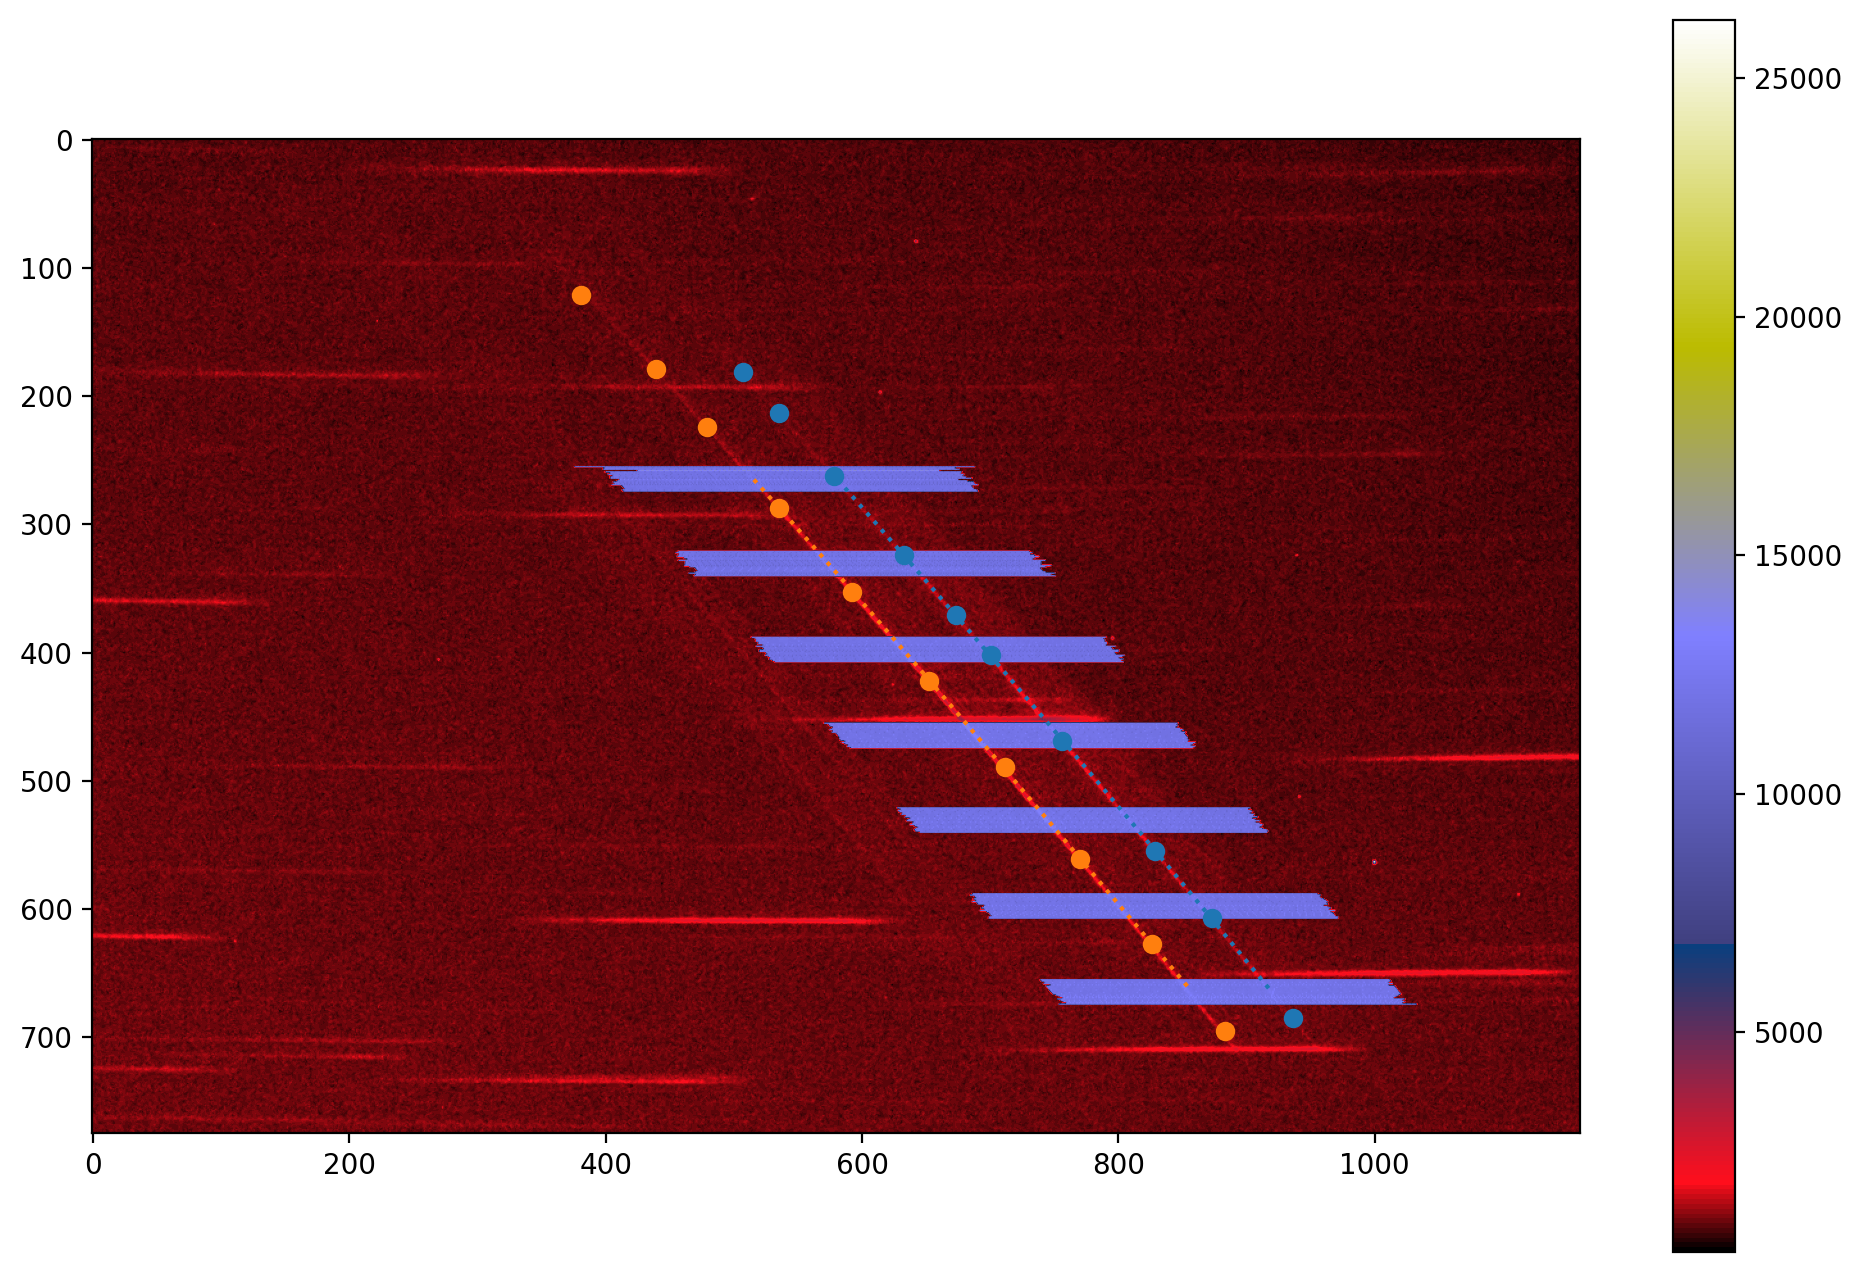

In [113]:
plt.figure()
plt.imshow(data2, cmap = plt.cm.gist_stern)
plt.colorbar()
yfit=np.arange(pos_center[1] - span_y//2, pos_center[1] + span_y//2, dtype=np.float64)
plt.plot(model1(yfit, *par1), yfit, ':', model1(yfit, *par2), yfit, ':')
plt.scatter(posxes_Na,posyes_Na)
plt.scatter(posxes_Mg,posyes_Mg)


calculate the Gaussian parameters

plot the spectrum

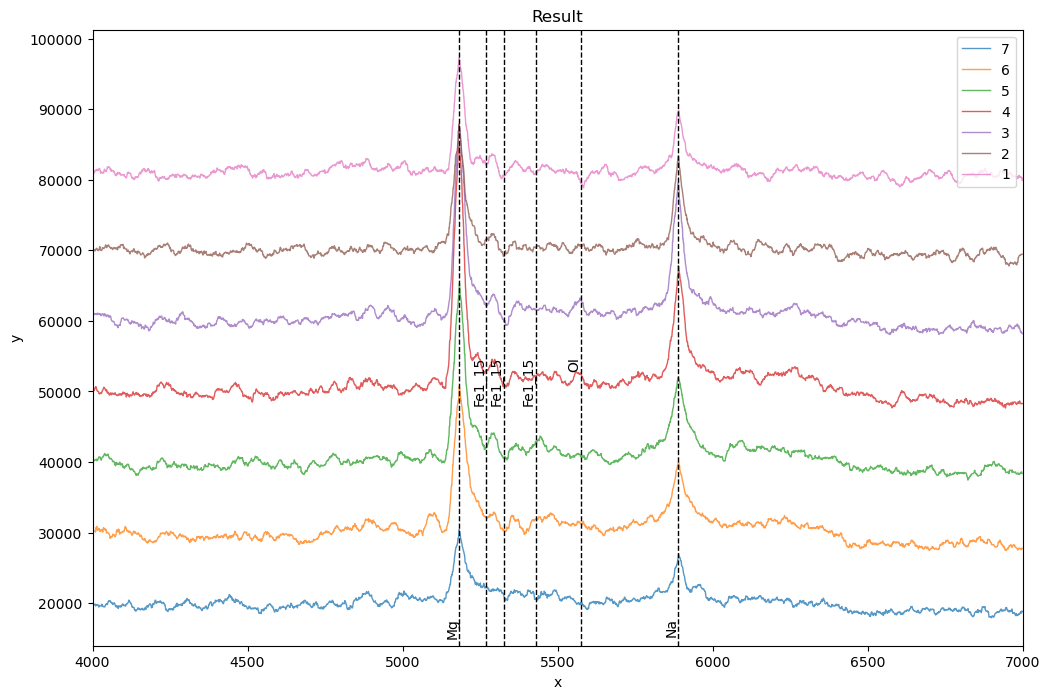

In [16]:
plt.figure()

'''specturm'''

for i in range(number): 
    plt.plot(lambdas, spectra[i]+i*10000, label = number-i, linewidth=1, alpha=0.75)

'''spectral lines'''

plt.axvline( lambda_Na, color='k', linewidth=1, linestyle='--')
plt.text(    lambda_Na, 18000, 'Na', rotation=90, va='top', ha='right')
plt.axvline( lambda_Mg, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_Mg, 18000, 'Mg', rotation=90, va='top', ha='right')
plt.axvline( lambda_OI, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_OI, 55000, 'OI', rotation=90, va='top', ha='right')
plt.axvline( lambda_Fe1_15, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_Fe1_15, 55000, 'Fe1_15', rotation=90, va='top', ha='right')
plt.axvline( lambda_Fe1_152, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_Fe1_152, 55000, 'Fe1_15', rotation=90, va='top', ha='right')
plt.axvline( lambda_Fe1_153, color='k',linewidth=1, linestyle='--')
plt.text(    lambda_Fe1_153, 55000, 'Fe1_15', rotation=90, va='top', ha='right')

plt.title('Result')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(4000, 7000)
plt.legend()
plt.show()

In [17]:
def model3(x, A, sigma, z):
    return A*np.exp(-x**2/(2*sigma**2)) + z# without mu

par_Na = []
par_Mg = []
background = np.average(spectra[i,2500:3000])
for i in range(number):
    '''Na'''
    xfit = np.arange(-50, 50)
    par0 = np.ones(model3.__code__.co_argcount-1) # initial guess for parameters
    par, cov = fitter.curve_fit(model3, xfit, spectra[i,lambda_Na-4000-50:lambda_Na-4000+50]+i*10000, par0, absolute_sigma=True)
    par_Na.append(par)
    '''Mg'''
    xfit = np.arange(-50, 50)
    par0 = np.ones(model3.__code__.co_argcount-1) # initial guess for parameters
    par, cov = fitter.curve_fit(model3, xfit, spectra[i,lambda_Mg-4000-50:lambda_Mg-4000+50]+i*10000, par0, absolute_sigma=True)
    par_Mg.append(par)


plot the Na/Mg ratio

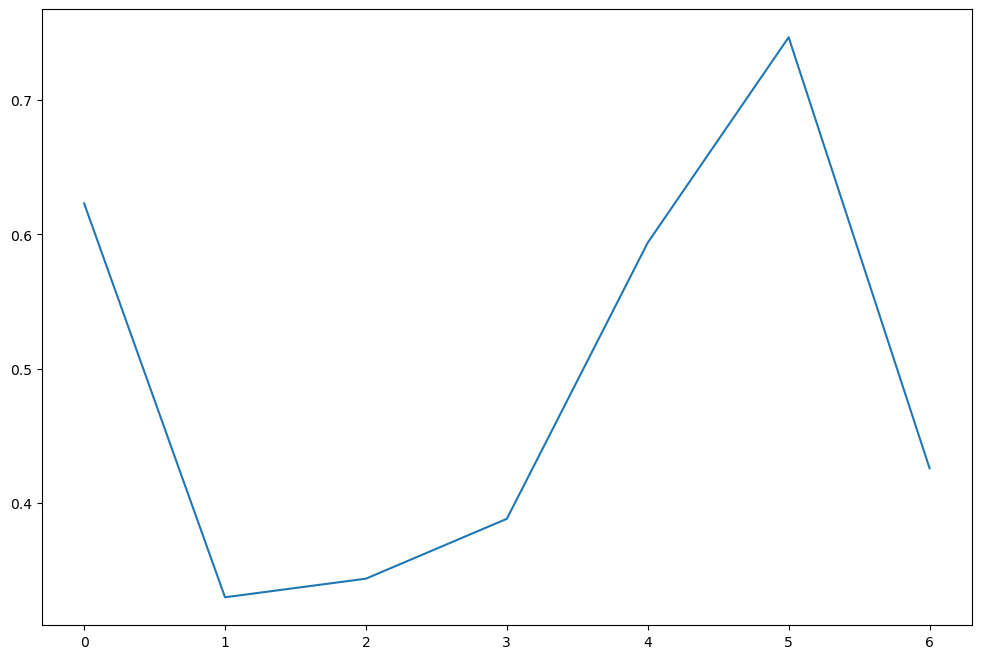

In [18]:
A_Na = np.array(par_Na)[:,0]
A_Mg = np.array(par_Mg)[:,0]

plt.figure()

plt.plot(np.arange(number), np.array(A_Na)/np.array(A_Mg))

plt.show()

In [127]:
def make_func(choice): 

    def func1(arg):
        print('func1:', arg)

    def func2(arg):
        print('func2:', arg)

    if choice=='func1': 
        return func1
    if choice=='func2': 
        return func2
        
test_func = make_func('func1')
test_func('hw')


func1: hw
